## Initialization

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/ProjetGo")

Mounted at /content/drive


In [3]:
!pip install pybind11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 6.4 MB/s eta 0:00:00


In [4]:
!c++ -O3 -Wall -shared -std=c++11 -fsized-deallocation -fPIC `python3 -m pybind11 --includes` golois.cpp -o golois.cpython-38-x86_64-linux-gnu.so

In file included from golois.cpp:17:0:
Board.h: In member function ‘bool Board::isCapturedLadder(int, int, Rzone*)’:
Board.h:1767:8: warning: unused variable ‘n1’ [-Wunused-variable]
    int n1 = nbLiberties (inter, liberties1, stones1, 3);
        ^~
Board.h:1788:12: warning: unused variable ‘n1’ [-Wunused-variable]
        int n1 = nbLiberties (inter, liberties1, stones1, 3);
            ^~
Board.h: In member function ‘void Board::computeLadders(int)’:
Board.h:1819:9: warning: unused variable ‘other’ [-Wunused-variable]
     int other = opponent (color);
         ^~~~~
Board.h: In member function ‘void Board::computeAllLadders(int, bool)’:
Board.h:2065:9: warning: unused variable ‘n1’ [-Wunused-variable]
     int n1 = nbLiberties (i, liberties1, stones1);
         ^~
Board.h:2101:7: warning: unused variable ‘n1’ [-Wunused-variable]
   int n1 = nbLiberties (i, liberties1, stones1);
       ^~
Board.h:2134:9: warning: unused variable ‘n1’ [-Wunused-variable]
     int n1 = nbLiberties (i

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras import regularizers
import gc

import golois

In [6]:
planes = 31
moves = 361
N = 10000

batch = 128
filters = 32

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)

getValidation


## Simple CV model

In [7]:
input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)


for i in range (3):
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)

policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
#policy_head = layers.MaxPooling2D(pool_size=(2,2))(policy_head)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)
value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
#value_head = layers.MaxPooling2D(pool_size=(2,2))(value_head)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

cv_model = keras.Model(inputs=input, outputs=[policy_head, value_head])

#cv_model.summary ()

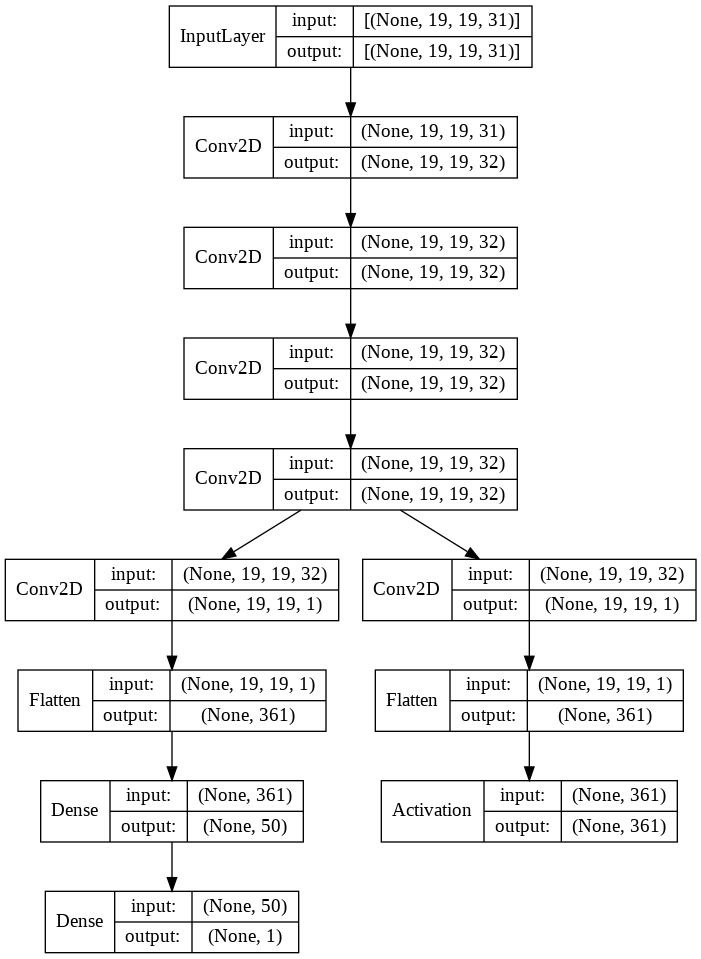

In [8]:
tf.keras.utils.plot_model(
    cv_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


## ShuffleNet 

In [9]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Reshape, Permute, Lambda, Flatten, Activation

def bottleneck_block(tensor, expand=96, squeeze=16):
  x = gconv(tensor, channels=expand, groups=4)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = channel_shuffle(x, groups=4)
  x = DepthwiseConv2D(kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)

  x = gconv(x, channels=squeeze, groups=4)
  x = BatchNormalization()(x)

  x = Add()([tensor, x])
  output = ReLU()(x)
  return output

def gconv(tensor, channels, groups):
  input_ch = tensor.get_shape().as_list()[-1]
  group_ch = input_ch // groups
  output_ch = channels // groups
  groups_list = []

  for i in range(groups):
    group_tensor = tensor[:, :, :, i * group_ch: (i+1) * group_ch]
    group_tensor = Conv2D(output_ch, 1)(group_tensor)
    groups_list.append(group_tensor)

  output = Concatenate()(groups_list)
  return output

def channel_shuffle(x, groups):
  _, width, height, channels = x.get_shape().as_list()
  group_ch = channels // groups

  x = Reshape([width, height, group_ch, groups])(x)
  x = Permute([1, 2, 4, 3])(x)
  x = Reshape([width, height, channels])(x)
  return x

def getModel (trunk=16,filters=32,blocks=1):
  input = keras.Input(shape=(19, 19, planes), name='board')
  x = Conv2D(trunk, 1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  for i in range (blocks):
    x = bottleneck_block (x, filters, trunk)

  policy_head = Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = Flatten()(policy_head)
  policy_head = Activation('softmax', name='policy')(policy_head)

  value_head = GlobalAveragePooling2D()(x)
  value_head = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
  value_head = Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

  model = keras.Model(inputs=input, outputs=[policy_head, value_head])
  return model


shuffle_net = getModel()



## MobileNet

In [10]:
def bottleneck_block(x, expand=96, squeeze=16):
  m = layers.Conv2D(expand, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.DepthwiseConv2D((3,3), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.Conv2D(squeeze, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  return layers.Add()([m, x])


input = layers.Input(shape=(19,19,31))
x = layers.Conv2D(16, 1, activation='relu', padding='same')(input)
for i in range (20):
  x = bottleneck_block(x)
#flatten = layers.Flatten()(x)
#x = layers.Dense(10, activation="softmax")(flatten)

policy_head = Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = Flatten()(policy_head)
policy_head = Activation('softmax', name='policy')(policy_head)

value_head = GlobalAveragePooling2D()(x)
value_head = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

mobile_net = tf.keras.models.Model(inputs=input, outputs=[policy_head, value_head])



## Light AlphaGo

In [11]:
def residual_layer(x):
  ident = x
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.add([ident,x])
  x = layers.Activation('relu')(x)
  return x

def conv_layer(x):
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  return x

def value_head(x):
  x = layers.Conv2D(1, 1, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256,activation='relu')(x)
  x = layers.Dense(1,activation='tanh',name='value')(x)
  return x

def policy_head(x):
  x = layers.Conv2D(1, 1, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Activation('softmax',name='policy')(x)
  return x


def get_LightAlphaGo(resid = 1):
  input = keras.Input(shape=(19, 19, planes), name='board')
  x = conv_layer(input)

  for i in range(resid):
    x = residual_layer(x)

  vh = value_head(x)
  ph = policy_head(x)

  model = keras.Model(inputs=input, outputs=[ph, vh])

  return model
  

alpha_go = get_LightAlphaGo()


alpha_go.summary ()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 19, 19, 256)  71680       ['board[0][0]']                  
                                                                                                  
 batch_normalization_64 (BatchN  (None, 19, 19, 256)  1024       ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                            

## MobileNet with MixConv

In [12]:
def mixconv(x, filters, **kwargs):
  # x: input features with shape [N,H,W,C]
  # filters: a list of filters with shape [K_i, K_i,C_i, M_i] for i−th group.
  G = len(filters) # number of groups.
  y = []
  n_ch = np.shape(x)[3]
  if G == 5:
    G=[19,19,19,19,20]
  for xi, fi in zip(tf.split(x, G, axis=3), filters):
    f = np.random.normal(size=fi).astype(np.float32)
    y.append(tf.nn.depthwise_conv2d(xi,f, **kwargs)) 
  return tf.concat(y, axis=3)


def bottleneck_block_mixconv(x, expand=96, squeeze=16):
  filters_mix = np.array([[3,3,24,1],[5,5,24,1],[7,7,24,1],[9,9,24,1]])
  m = layers.Conv2D(expand, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = mixconv(m,filters_mix,strides=[1,1,1,1],padding='SAME')
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.Conv2D(squeeze, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  return layers.Add()([m, x])


input = layers.Input(shape=(19,19,31))
x = layers.Conv2D(16, 1, activation='relu', padding='same')(input)
for i in range (25):
  x = bottleneck_block_mixconv(x)

policy_head = Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = Flatten()(policy_head)
policy_head = Activation('softmax', name='policy')(policy_head)

value_head = GlobalAveragePooling2D()(x)
value_head = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

mobile_net_mix = tf.keras.models.Model(inputs=input, outputs=[policy_head, value_head])

mobile_net_mix.count_params()

99029

## MixNet

In [ ]:
def get_mixnet_s():
  input = keras.Input(shape=(19, 19, planes), name='board')
  #x = layers.Conv2D(16, 1, activation='relu', padding='same')(input)
  filters_mix2 = np.array([[3,3,48,1],[5,5,48,1]])
  filters_mix3 = np.array([[3,3,32,1],[5,5,32,1],[7,7,32,1]])
  filters_mix4 = np.array([[3,3,24,1],[5,5,24,1],[7,7,24,1],[9,9,24,1]])
  filters_mix5 = np.array([[3,3,19,1],[5,5,19,1],[7,7,19,1],[9,9,19,1],[11,11,20,1]])


  ## stem ?
  x = layers.Conv2D(96, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.DepthwiseConv2D((3,3), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
  x = layers.DepthwiseConv2D((3,3), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
  x = layers.DepthwiseConv2D((3,3), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)

  x = mixconv(x,filters_mix3,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix2,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix2,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix2,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix3,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix2,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix2,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix3,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix3,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix3,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix5,strides=[1,1,1,1],padding='SAME')

  x = mixconv(x,filters_mix4,strides=[1,1,1,1],padding='SAME')
  x = mixconv(x,filters_mix4,strides=[1,1,1,1],padding='SAME')

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(16, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
  x = layers.BatchNormalization()(x)





  policy_head = Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = Flatten()(policy_head)
  policy_head = Activation('softmax', name='policy')(policy_head)

  value_head = GlobalAveragePooling2D()(x)
  value_head = Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
  value_head = Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

  return tf.keras.models.Model(inputs=input, outputs=[policy_head, value_head])



mix_net = get_mixnet_s()
mix_net.count_params()

8853

In [ ]:
tf.keras.utils.plot_model(
    mix_net,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

## Train

In [13]:
epochs = 800

model = mobile_net
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 1.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

for i in range (1, epochs + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value}, 
                        epochs=1, batch_size=batch)
    if (i % 5 == 0):
        gc.collect ()
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        print ("val =", val)




/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch 1
79/79 [==============================] - 23s 115ms/step - loss: 12.7064 - policy_loss: 11.8613 - value_loss: 0.7318 - policy_categorical_accuracy: 0.0043 - value_mse: 0.1373
epoch 2
79/79 [==============================] - 9s 114ms/step - loss: 8.5877 - policy_loss: 7.7710 - value_loss: 0.7033 - policy_categorical_accuracy: 0.0042 - value_mse: 0.1241
epoch 3
79/79 [==============================] - 9s 114ms/step - loss: 7.3718 - policy_loss: 6.5580 - value_loss: 0.7004 - policy_categorical_accuracy: 0.0047 - value_mse: 0.1239
epoch 4
79/79 [==============================] - 9s 116ms/step - loss: 6.8893 - policy_loss: 6.0807 - value_loss: 0.6953 - policy_categorical_accuracy: 0.0046 - value_mse: 0.1217
epoch 5
79/79 [==============================] - 9s 117ms/step - loss: 6.7642 - policy_loss: 5.9553 - value_loss: 0.6956 - policy_categorical_accuracy: 0.0061 - value_mse: 0.1206
epoch 6
79/79 [==============================] - 9s 120ms/step - loss: 6.7285 - policy_loss: 5.9247 - 

In [15]:
for i in range (1, 200 + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value}, 
                        epochs=1, batch_size=batch)
    if (i % 5 == 0):
        gc.collect ()
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        print ("val =", val)

epoch 1
79/79 [==============================] - 9s 115ms/step - loss: 3.1594 - policy_loss: 2.4399 - value_loss: 0.6307 - policy_categorical_accuracy: 0.3868 - value_mse: 0.0936
epoch 2
79/79 [==============================] - 9s 117ms/step - loss: 3.1502 - policy_loss: 2.4270 - value_loss: 0.6344 - policy_categorical_accuracy: 0.3882 - value_mse: 0.0930
epoch 3
79/79 [==============================] - 9s 118ms/step - loss: 3.1945 - policy_loss: 2.4749 - value_loss: 0.6308 - policy_categorical_accuracy: 0.3736 - value_mse: 0.0927
epoch 4
79/79 [==============================] - 9s 118ms/step - loss: 3.1372 - policy_loss: 2.4117 - value_loss: 0.6367 - policy_categorical_accuracy: 0.3917 - value_mse: 0.0954
epoch 5
79/79 [==============================] - 9s 117ms/step - loss: 3.1544 - policy_loss: 2.4353 - value_loss: 0.6303 - policy_categorical_accuracy: 0.3853 - value_mse: 0.0916
epoch 6
79/79 [==============================] - 9s 116ms/step - loss: 3.1769 - policy_loss: 2.4517 - val

In [16]:
model.save ('wemaere3.h5')

## Note:

Optimizer = SGD

shufflenet, 5 blocks, 100 epochs: [3.6671507358551025, 2.973344564437866, 0.6888183951377869, 0.311599999666214, 0.1178920641541481]

shufflenet, 20 blocks, 100 epochs: [3.8185436725616455, 3.1244289875030518, 0.6892627477645874, 0.29660001397132874, 0.1181161105632782]

shufflenet, 10 blocks, 200 epochs:  [3.758380174636841, 3.0648369789123535, 0.6886175870895386, 0.30709999799728394, 0.11779239773750305]

shufflenet, 15 blocks, 300 epochs: [4.3218488693237305, 3.6299538612365723, 0.6871563196182251, 0.219200000166893, 0.11708950251340866]

Mobilenet, 5 blocks, 100 epochs: val = [3.5152745246887207, 2.805683135986328, 0.6798425316810608, 0.3384999930858612, 0.11350224912166595]

Mobilenet, 5 blocks, 100 epochs:val = [3.3442671298980713, 2.6600968837738037, 0.6549816131591797, 0.3598000109195709, 0.10215248912572861]


Optmizer = Adam

Mobilenet, 15 blocks, 300 epochs: val = [3.37707257270813, 2.6415462493896484, 0.6587250232696533, 0.3562999963760376, 0.10392116755247116]


Mobilenet, 15 blocks, 400 epochs: val = [3.3066883087158203, 2.5775811672210693, 0.6543009877204895, 0.36660000681877136, 0.10200804471969604]


Mobilenet, 15 blocks, 500 epochs:  val = [3.2480053901672363, 2.5301172733306885, 0.6448714137077332, 0.37130001187324524, 0.09802383184432983]



Mobilenet, 15 blocks, 600 epochs: val = [3.217024564743042, 2.505136251449585, 0.6404983401298523, 0.37540000677108765, 0.09604021906852722]


Mobilenet, 20 blocks, 500 epochs: val = [3.2398760318756104, 2.509153127670288, 0.6376951336860657, 0.37880000472068787, 0.09495193511247635]

600 epochs: val = [3.206523895263672, 2.475412607192993, 0.6407206058502197, 0.3774999976158142, 0.0962781235575676]

Mixnet S 400 epochs: val = [4.188157558441162, 3.4964113235473633, 0.6756730675697327, 0.27959999442100525, 0.11151006072759628]